In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from collections import Counter

In [3]:
df = pd.read_csv("churn_prediction.csv")
df.shape

(28382, 21)

In [4]:
df['churn'].value_counts()

0    23122
1     5260
Name: churn, dtype: int64

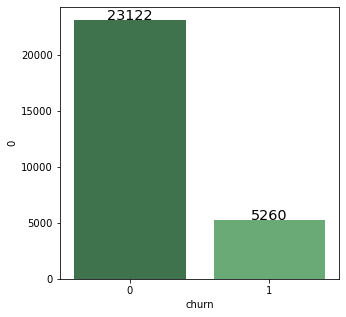

In [5]:
#Calculating count of Stroke vs No Stroke cases
plt.figure(figsize=(5,5))
target_group = df.groupby('churn').size().reset_index()
pal = sns.color_palette("Greens_d", len(target_group))
rank = target_group["churn"].argsort().argsort()
g = sns.barplot(x = target_group['churn'],y = target_group[0],palette=np.array(pal[::-1])[rank] )

for index, row in target_group.iterrows():
    g.text(row['churn'],row[0], round(row[0],2), color='black', ha="center",fontsize='x-large')

# Data Preprocessing

In [4]:
df.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
last_transaction                     0
dtype: int64

### 1. Missing value Treatment

In [5]:
#Convert Gender
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

# Replace with -1 for missing gender
df['gender'] = df['gender'].fillna(-1)

# Replacing with max. occurence values
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')
df['city'] = df['city'].fillna(1020)

### 2. Dummy Variables

In [6]:
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

In [7]:
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,...,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,1,2101,66,1.0,0.0,self_employed,187.0,2,755,1458.71,...,0.20,1458.71,1458.71,0,21-05-2019,0,0,0,1,0
1,2,2348,35,1.0,0.0,self_employed,1020.0,2,3214,5390.37,...,100.56,6496.78,8787.61,0,01-11-2019,0,0,0,1,0
2,4,2194,31,1.0,0.0,salaried,146.0,2,41,3913.16,...,259.23,5006.28,5070.14,0,NaT,0,0,1,0,0
3,5,2329,90,-1.0,0.0,self_employed,1020.0,2,582,2291.91,...,2143.33,2291.91,1669.79,1,06-08-2019,0,0,0,1,0
4,6,1579,42,1.0,2.0,self_employed,1494.0,3,388,927.72,...,1538.06,1157.15,1677.16,1,03-11-2019,0,0,0,1,0


# Train and Test Split

In [8]:
#x = df.drop('Attrition', axis=1)
x = df.drop(['churn','customer_id', 'occupation', 'last_transaction'], axis=1)
y = df['churn']
# Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size=0.8, stratify = y, random_state=100)

In [9]:
y_train.shape, y_test.shape

((22705,), (5677,))

In [10]:
y_train.value_counts()/len(y_train)

0    0.814666
1    0.185334
Name: churn, dtype: float64

In [11]:
    y_test.value_counts()/len(y_test)

0    0.814691
1    0.185309
Name: churn, dtype: float64

In [12]:
from sklearn.preprocessing import StandardScaler
Scaler_X = StandardScaler()
X_train = Scaler_X.fit_transform(X_train)
X_test = Scaler_X.transform(X_test)

# Applying different Techniques to handle class imbalance

## 1. Over Sampling

### 1.1 Random Over Sampling

In [13]:
from imblearn.over_sampling import RandomOverSampler

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using Random Over Sampling
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

counter = Counter(y_train_ros)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 18497, 1: 18497})


 ### 1.2 SMOTE 

In [14]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 18497, 1: 18497})


### 1.3 ADASYN

In [15]:
from imblearn.over_sampling import ADASYN

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN()
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 18497, 1: 17388})


## 2. Under Sampling

### 2.1 Random Under Sampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using Random Under Sampling
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

counter = Counter(y_train_rus)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 4208, 1: 4208})


### 2.2 Tomek Links

In [17]:
from imblearn.under_sampling import TomekLinks

counter = Counter(y_train)
print('Before',counter)
# undersampling the train dataset using TomekLinks
toml = TomekLinks()
X_train_toml, y_train_toml = toml.fit_resample(X_train, y_train)

counter = Counter(y_train_toml)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 17142, 1: 4208})


### 2.3 Near Miss

In [18]:
from imblearn.under_sampling import NearMiss

counter = Counter(y_train)
print('Before',counter)
# undersampling the train dataset using Near Miss
nm = NearMiss()
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

counter = Counter(y_train_nm)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 4208, 1: 4208})


## 3. Hybrid Techniques

### 3.1 SMOTE + Tomek Links

In [19]:
from imblearn.combine import SMOTETomek

counter = Counter(y_train)
print('Before',counter)
# oversampling thehttp://localhost:8888/notebooks/Imbalanced-Data-Analysis/Churn%20Prediction/Churn%20prediction.ipynb#3.2-SMOTE-+-ENN train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 18090, 1: 18090})


### 3.2 SMOTE + ENN

In [20]:
from imblearn.combine import SMOTEENN

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({1: 14680, 0: 8975})


# Visualizing Resampled Data

In [21]:
from sklearn.datasets import make_classification

In [22]:
X, Y = make_classification(n_samples=20000, n_features=2, n_informative=2,
                            n_redundant=0, n_repeated=0, n_classes=2,
                            n_clusters_per_class=1,
                            weights=[0.95, 0.05],
                            class_sep=0.8, random_state=100)

In [23]:
X1, X2 = list(), list()
for i, j in enumerate(X):
    X1.append(j[0])
    X2.append(j[1])

In [24]:
df = pd.DataFrame({'X1':X1, 'X2':X2, 'Y':Y})

In [25]:
pal = sns.color_palette('tab10')
print(pal.as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


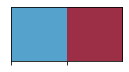

In [26]:
#sns.set_palette('icefire')
sns.set_palette(['#55a3cd', '#9c2f45'])
sns.palplot(sns.color_palette())

## Imblanced Data

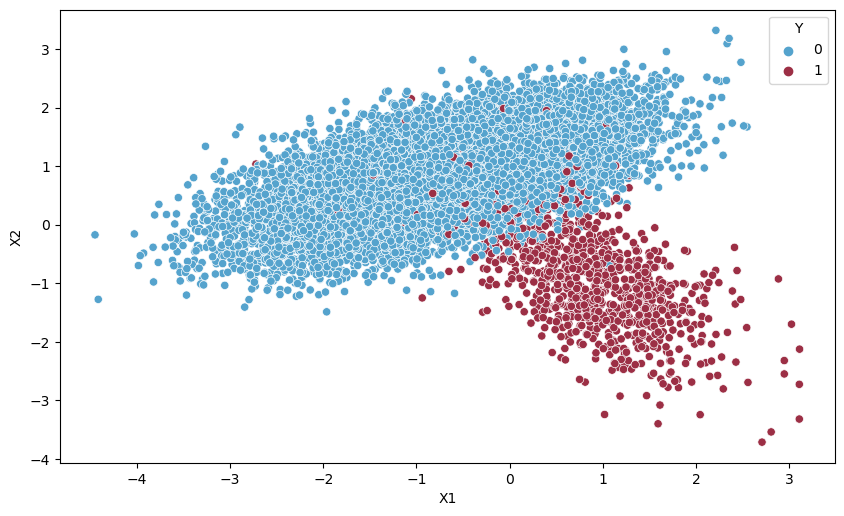

In [27]:
plt.figure(figsize=(10,6),dpi=100)

sns.despine(left=True)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df)
plt.show()

In [28]:
df['Y'].value_counts()

0    18909
1     1091
Name: Y, dtype: int64

In [29]:
x = df.drop('Y', axis=1)
y = df['Y']

## With Resampling Techniques

In [30]:
counter = Counter(y)
ros = RandomOverSampler()
X_train1, y_train1 = ros.fit_resample(x, y)
counter = Counter(y_train1)
df_ros = X_train1.copy()
df_ros['Y'] = y_train1

counter = Counter(y)
smt = SMOTE()
X_train1, y_train1 = smt.fit_resample(x, y)
counter = Counter(y_train1)
df_sm = X_train1.copy()
df_sm['Y'] = y_train1

counter = Counter(y)
ada = ADASYN()
X_train1, y_train1 = ada.fit_resample(x, y)
counter = Counter(y_train1)
df_ada = X_train1.copy()
df_ada['Y'] = y_train1

counter = Counter(y)
rus = RandomUnderSampler()
X_train1, y_train1 = rus.fit_resample(x, y)
counter = Counter(y_train1)
df_rus = X_train1.copy()
df_rus['Y'] = y_train1

counter = Counter(y)
toml = TomekLinks()
X_train1, y_train1 = toml.fit_resample(x, y)
counter = Counter(y_train1)
df_toml = X_train1.copy()
df_toml['Y'] = y_train1

counter = Counter(y)
nm = NearMiss()
X_train1, y_train1 = nm.fit_resample(x, y)
counter = Counter(y_train1)
df_nm = X_train1.copy()
df_nm['Y'] = y_train1

counter = Counter(y)
smtom = SMOTETomek()
X_train1, y_train1 = smtom.fit_resample(x, y)
counter = Counter(y_train1)
df_smtom = X_train1.copy()
df_smtom['Y'] = y_train1

counter = Counter(y)
smenn = SMOTEENN()
X_train1, y_train1 = smenn.fit_resample(x, y)
counter = Counter(y_train1)
df_smenn = X_train1.copy()
df_smenn['Y'] = y_train1


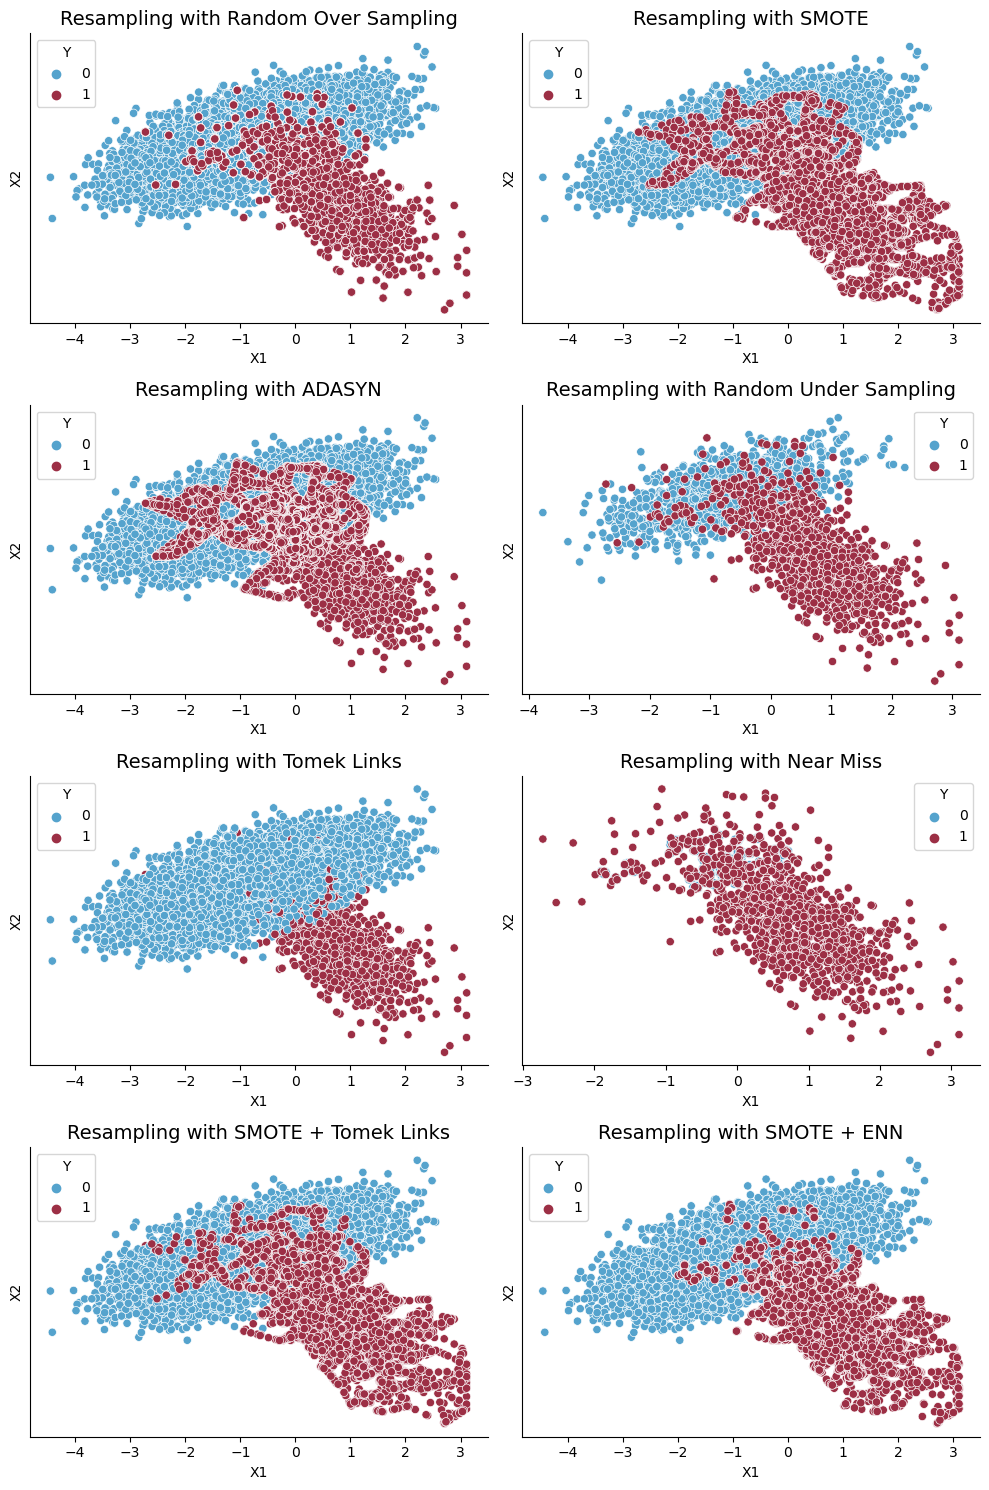

In [31]:
f, axes = plt.subplots(4,2,figsize=(10, 15), dpi=100)
sns.despine()
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_ros, ax=axes[0,0])
axes[0,0].set_title('Resampling with Random Over Sampling', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_sm, ax=axes[0,1])
axes[0,1].set_title('Resampling with SMOTE', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_ada, ax=axes[1,0])
axes[1,0].set_title('Resampling with ADASYN', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_rus, ax=axes[1,1])
axes[1,1].set_title('Resampling with Random Under Sampling', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_toml, ax=axes[2,0])
axes[2,0].set_title('Resampling with Tomek Links', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_nm, ax=axes[2,1])
axes[2,1].set_title('Resampling with Near Miss', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_smtom, ax=axes[3,0])
axes[3,0].set_title('Resampling with SMOTE + Tomek Links', fontsize=14)
sns.scatterplot(x='X1', y='X2', hue = 'Y', data=df_smenn, ax=axes[3,1])
axes[3,1].set_title('Resampling with SMOTE + ENN', fontsize=14)
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

# Building Models

In [32]:
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [33]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    plot_confusion_matrix(clf_model, X_test, y_test)  
    plt.show()
    #print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    resample.append(sampling)

## Model-1: Logistic Regression

### 1. Original Unsampled Data 

In [34]:
log_model=LogisticRegression()

params={'C':np.logspace(-10, 1, 15),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# Create grid search using 5-fold cross validation
clf_LR = GridSearchCV(log_model, params, cv=cv, scoring='roc_auc', n_jobs=-1)
clf_LR.fit(X_train, y_train)
clf_LR.best_estimator_

C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
Va

LogisticRegression(C=10.0)

C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix


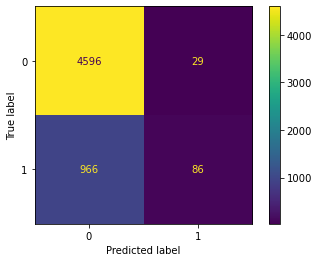

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      4625
           1       0.75      0.08      0.15      1052

    accuracy                           0.82      5677
   macro avg       0.79      0.54      0.52      5677
weighted avg       0.81      0.82      0.76      5677
 

AUC-ROC
0.7734372623574144


In [35]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'actual')

### 2. Random Over Resampling

In [36]:
clf_LR.fit(X_train_ros, y_train_ros)
clf_LR.best_estimator_

C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
Va

LogisticRegression(C=10.0)

C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix


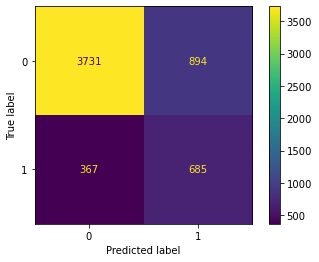

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      4625
           1       0.43      0.65      0.52      1052

    accuracy                           0.78      5677
   macro avg       0.67      0.73      0.69      5677
weighted avg       0.82      0.78      0.79      5677
 

AUC-ROC
0.7714734354125989


In [37]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'random os')

### 3. SMOTE Resampling

In [38]:
clf_LR.fit(X_train_sm, y_train_sm)
clf_LR.best_estimator_

C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
Va

LogisticRegression(C=10.0)

C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix


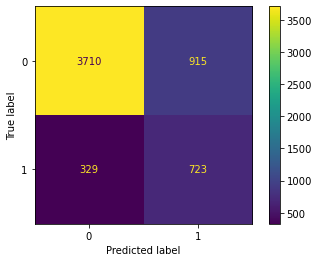

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      4625
           1       0.44      0.69      0.54      1052

    accuracy                           0.78      5677
   macro avg       0.68      0.74      0.70      5677
weighted avg       0.83      0.78      0.80      5677
 

AUC-ROC
0.7771392457095878


In [39]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote')

### 4. ADASYN Resampling

In [40]:
clf_LR.fit(X_train_ada, y_train_ada)
clf_LR.best_estimator_

C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
Va

LogisticRegression(C=10.0)

C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix


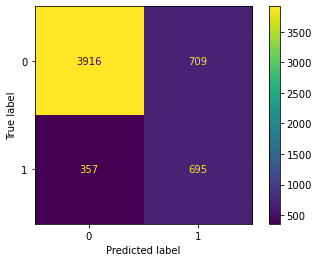

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      4625
           1       0.50      0.66      0.57      1052

    accuracy                           0.81      5677
   macro avg       0.71      0.75      0.72      5677
weighted avg       0.84      0.81      0.82      5677
 

AUC-ROC
0.7803699517007501


In [41]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'adasyn')

### 5. Random Under Resampling

In [42]:
clf_LR.fit(X_train_rus, y_train_rus)
clf_LR.best_estimator_

C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
Va

LogisticRegression(C=10.0, class_weight='balanced')

C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix


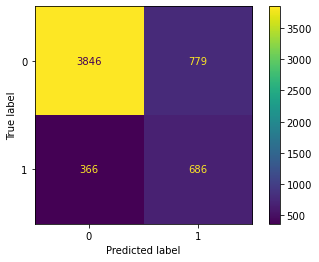

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      4625
           1       0.47      0.65      0.55      1052

    accuracy                           0.80      5677
   macro avg       0.69      0.74      0.71      5677
weighted avg       0.83      0.80      0.81      5677
 

AUC-ROC
0.775875244065358


In [43]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'random us')

### 6. Tomek Links Resampling

In [44]:
clf_LR.fit(X_train_toml, y_train_toml)
clf_LR.best_estimator_

C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
Va

LogisticRegression(C=10.0)

C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix


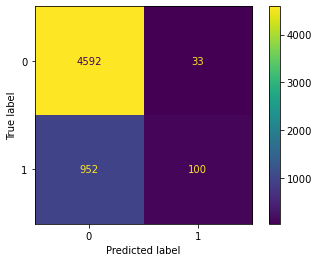

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      4625
           1       0.75      0.10      0.17      1052

    accuracy                           0.83      5677
   macro avg       0.79      0.54      0.54      5677
weighted avg       0.81      0.83      0.77      5677
 

AUC-ROC
0.772583496043572


In [45]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'tomek links')

### 7. Near Miss Resampling

In [46]:
clf_LR.fit(X_train_nm, y_train_nm)
clf_LR.best_estimator_

C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
Va

LogisticRegression(C=10.0, class_weight='balanced')

C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix


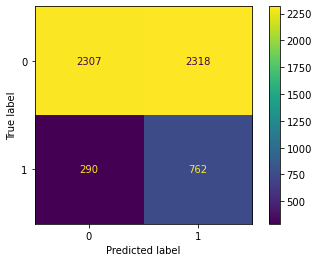

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.50      0.64      4625
           1       0.25      0.72      0.37      1052

    accuracy                           0.54      5677
   macro avg       0.57      0.61      0.50      5677
weighted avg       0.77      0.54      0.59      5677
 

AUC-ROC
0.6607798787380537


In [47]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'near miss')

### 8. SMOTE + Tomek Resampling

In [48]:
clf_LR.fit(X_train_smtom, y_train_smtom)
clf_LR.best_estimator_

C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
Va

LogisticRegression(C=10.0)

C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix


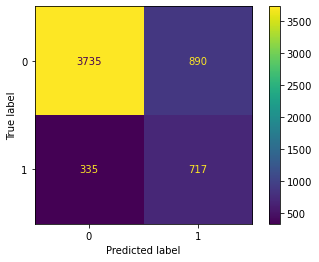

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4625
           1       0.45      0.68      0.54      1052

    accuracy                           0.78      5677
   macro avg       0.68      0.74      0.70      5677
weighted avg       0.83      0.78      0.80      5677
 

AUC-ROC
0.7783409721508581


In [49]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote+tomek')

### 9. SMOTE + ENN Resampling

In [50]:
clf_LR.fit(X_train_smenn, y_train_smenn)
clf_LR.best_estimator_

C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\study\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(
Va

LogisticRegression(C=10.0, class_weight='balanced')

C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion Matrix


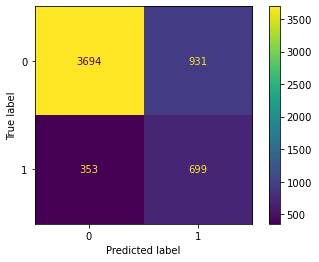

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      4625
           1       0.43      0.66      0.52      1052

    accuracy                           0.77      5677
   macro avg       0.67      0.73      0.69      5677
weighted avg       0.82      0.77      0.79      5677
 

AUC-ROC
0.773230294933717


In [51]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote+enn')

## Model-2: Decision Tree

In [52]:
estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

### 1. Original Unsampled Data

In [53]:
tree_model = DecisionTreeClassifier()

tree_param_grid = { 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf_DT.fit(X_train, y_train)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=9, min_samples_split=100)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


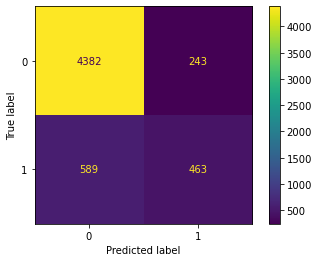

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4625
           1       0.66      0.44      0.53      1052

    accuracy                           0.85      5677
   macro avg       0.77      0.69      0.72      5677
weighted avg       0.84      0.85      0.84      5677
 

AUC-ROC
0.7936000411057446


In [54]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'actual')

### 2. Random Over Resampling

In [55]:
clf_DT.fit(X_train_ros, y_train_ros)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=15)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


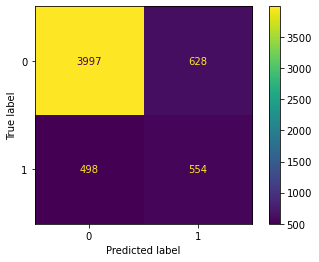

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      4625
           1       0.47      0.53      0.50      1052

    accuracy                           0.80      5677
   macro avg       0.68      0.70      0.69      5677
weighted avg       0.81      0.80      0.81      5677
 

AUC-ROC
0.6541221868256089


In [56]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'random os')

### 3. SMOTE Resampling

In [57]:
clf_DT.fit(X_train_sm, y_train_sm)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=7)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


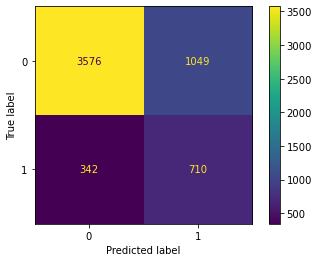

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.77      0.84      4625
           1       0.40      0.67      0.51      1052

    accuracy                           0.75      5677
   macro avg       0.66      0.72      0.67      5677
weighted avg       0.82      0.75      0.78      5677
 

AUC-ROC
0.7825802075840098


In [58]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote')

### 4. ADASYN Resampling

In [59]:
clf_DT.fit(X_train_ada, y_train_ada)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=50)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


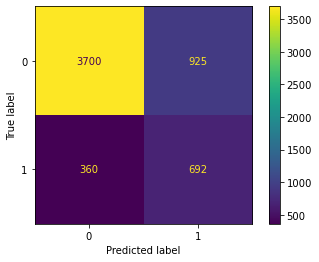

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      4625
           1       0.43      0.66      0.52      1052

    accuracy                           0.77      5677
   macro avg       0.67      0.73      0.69      5677
weighted avg       0.82      0.77      0.79      5677
 

AUC-ROC
0.7863799198437982


In [60]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'adasyn')

### 5. Random Under Resampling

In [61]:
clf_DT.fit(X_train_rus, y_train_rus)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=5, min_samples_split=100)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


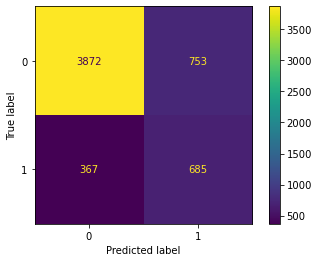

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      4625
           1       0.48      0.65      0.55      1052

    accuracy                           0.80      5677
   macro avg       0.69      0.74      0.71      5677
weighted avg       0.83      0.80      0.81      5677
 

AUC-ROC
0.8002505395128969


In [62]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'random us')

### 6. Tomek Links Resampling

In [63]:
clf_DT.fit(X_train_toml, y_train_toml)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=100)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


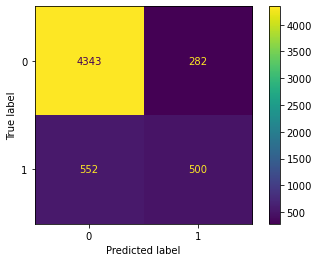

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      4625
           1       0.64      0.48      0.55      1052

    accuracy                           0.85      5677
   macro avg       0.76      0.71      0.73      5677
weighted avg       0.84      0.85      0.84      5677
 

AUC-ROC
0.8069386496762923


In [64]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'tomek links')

### 7. Near Miss Resampling

In [65]:
clf_DT.fit(X_train_nm, y_train_nm)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=50)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


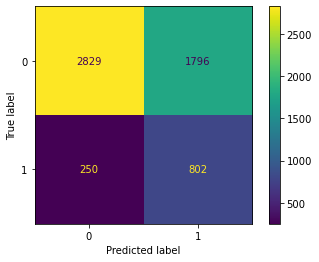

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      4625
           1       0.31      0.76      0.44      1052

    accuracy                           0.64      5677
   macro avg       0.61      0.69      0.59      5677
weighted avg       0.81      0.64      0.68      5677
 

AUC-ROC
0.7142190936183332


In [66]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'near miss')

### 8. SMOTE + Tomek Resampling

In [67]:
clf_DT.fit(X_train_smtom, y_train_smtom)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=100)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


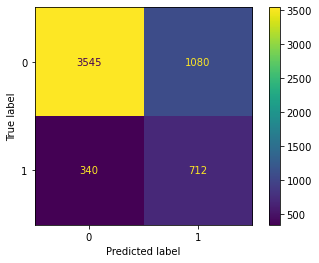

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.77      0.83      4625
           1       0.40      0.68      0.50      1052

    accuracy                           0.75      5677
   macro avg       0.65      0.72      0.67      5677
weighted avg       0.82      0.75      0.77      5677
 

AUC-ROC
0.789505292364608


In [68]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote+tomek')

### 9. SMOTE + ENN Resampling

In [69]:
clf_DT.fit(X_train_smenn, y_train_smenn)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=15, min_samples_split=100)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


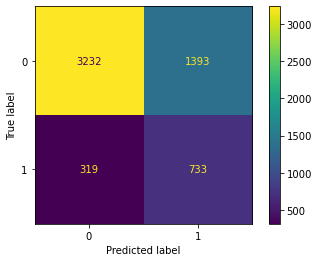

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      4625
           1       0.34      0.70      0.46      1052

    accuracy                           0.70      5677
   macro avg       0.63      0.70      0.63      5677
weighted avg       0.81      0.70      0.73      5677
 

AUC-ROC
0.7643997533655328


In [70]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote+enn')

## Model-3: Random Forest

### 1. Original Unsampled Data

In [71]:
rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_depth':max_depth,
           'min_samples_split':min_samples_split}

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1, n_iter=20, verbose=2)
clf_RF.fit(X_train, y_train)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=13, min_samples_split=10, n_estimators=50)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


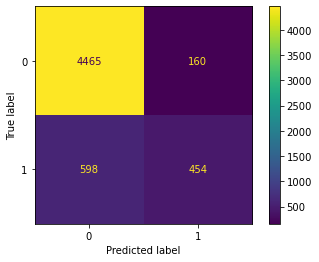

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      4625
           1       0.74      0.43      0.55      1052

    accuracy                           0.87      5677
   macro avg       0.81      0.70      0.73      5677
weighted avg       0.86      0.87      0.85      5677
 

AUC-ROC
0.830039255986024


In [72]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'actual')

### 2. Random Over Resampling

In [73]:
clf_RF.fit(X_train_ros, y_train_ros)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=30)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


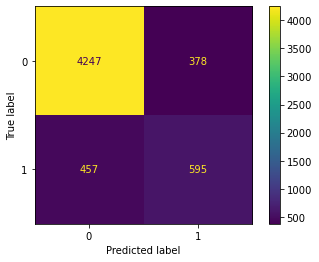

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4625
           1       0.61      0.57      0.59      1052

    accuracy                           0.85      5677
   macro avg       0.76      0.74      0.75      5677
weighted avg       0.85      0.85      0.85      5677
 

AUC-ROC
0.8207678553077792


In [74]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'random os')

### 3. SMOTE Resampling

In [75]:
clf_RF.fit(X_train_sm, y_train_sm)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=50)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


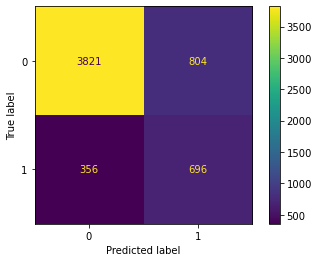

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      4625
           1       0.46      0.66      0.55      1052

    accuracy                           0.80      5677
   macro avg       0.69      0.74      0.71      5677
weighted avg       0.83      0.80      0.81      5677
 

AUC-ROC
0.8115260507655945


In [76]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote')

### 4. ADASYN Resampling

In [77]:
clf_RF.fit(X_train_ada, y_train_ada)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=15)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


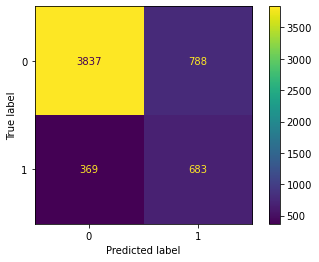

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      4625
           1       0.46      0.65      0.54      1052

    accuracy                           0.80      5677
   macro avg       0.69      0.74      0.71      5677
weighted avg       0.83      0.80      0.81      5677
 

AUC-ROC
0.8104203062377966


In [78]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'adasyn')

### 5. Random Under Resampling

In [79]:
clf_RF.fit(X_train_rus, y_train_rus)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=13, min_samples_split=10)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


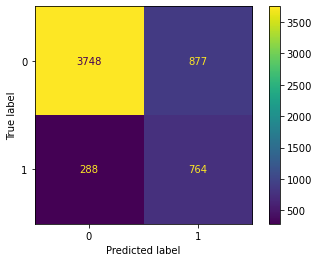

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      4625
           1       0.47      0.73      0.57      1052

    accuracy                           0.79      5677
   macro avg       0.70      0.77      0.72      5677
weighted avg       0.84      0.79      0.81      5677
 

AUC-ROC
0.8301479806803


In [80]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'random us')

### 6.  Tomek Links Resampling

In [81]:
clf_RF.fit(X_train_toml, y_train_toml)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=15, min_samples_split=5)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


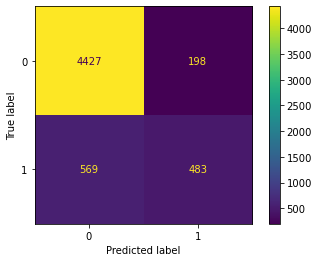

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      4625
           1       0.71      0.46      0.56      1052

    accuracy                           0.86      5677
   macro avg       0.80      0.71      0.74      5677
weighted avg       0.85      0.86      0.85      5677
 

AUC-ROC
0.8316321035864762


In [82]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'tomek links')

### 7. Near Miss Resampling

In [83]:
clf_RF.fit(X_train_nm, y_train_nm)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=13, min_samples_split=5, n_estimators=50)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


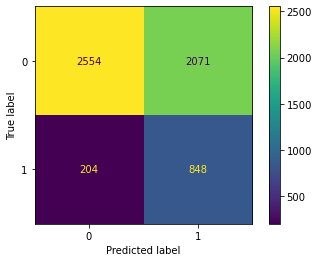

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.55      0.69      4625
           1       0.29      0.81      0.43      1052

    accuracy                           0.60      5677
   macro avg       0.61      0.68      0.56      5677
weighted avg       0.81      0.60      0.64      5677
 

AUC-ROC
0.7411136573836192


In [84]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'near miss')

### 8. SMOTE + Tomek Resampling

In [85]:
clf_RF.fit(X_train_smtom, y_train_smtom)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=15, min_samples_split=5)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


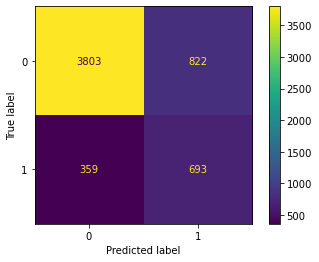

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.82      0.87      4625
           1       0.46      0.66      0.54      1052

    accuracy                           0.79      5677
   macro avg       0.69      0.74      0.70      5677
weighted avg       0.83      0.79      0.81      5677
 

AUC-ROC
0.8098592128249924


In [86]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote+tomek')

### 9. SMOTE + ENN Resampling

In [87]:
clf_RF.fit(X_train_smenn, y_train_smenn)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=50)

Confusion Matrix


C:\Users\study\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


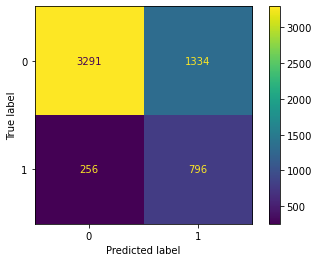

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.71      0.81      4625
           1       0.37      0.76      0.50      1052

    accuracy                           0.72      5677
   macro avg       0.65      0.73      0.65      5677
weighted avg       0.83      0.72      0.75      5677
 

AUC-ROC
0.8019679375192682


In [88]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote+enn')

# Comparitive Analysis

In [89]:
clf_eval_df = pd.DataFrame({'model':model,
                            'resample':resample,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score,
                            'AUC-ROC':AUCROC})

In [90]:
clf_eval_df

,model,resample,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,actual,0.747826,0.081749,0.147386,0.773437
1,Logistic Regression,random os,0.433819,0.651141,0.520715,0.771473
2,Logistic Regression,smote,0.441392,0.687262,0.537546,0.777139
3,Logistic Regression,adasyn,0.495014,0.660646,0.565961,0.780370
4,Logistic Regression,random us,0.468259,0.652091,0.545093,0.775875
5,Logistic Regression,tomek links,0.751880,0.095057,0.168776,0.772583
6,Logistic Regression,near miss,0.247403,0.724335,0.368829,0.660780
7,Logistic Regression,smote+tomek,0.446173,0.681559,0.539300,0.778341
8,Logistic Regression,smote+enn,0.428834,0.664449,0.521253,0.773230
9,Decision Tree,actual,0.655807,0.440114,0.526735,0.793600


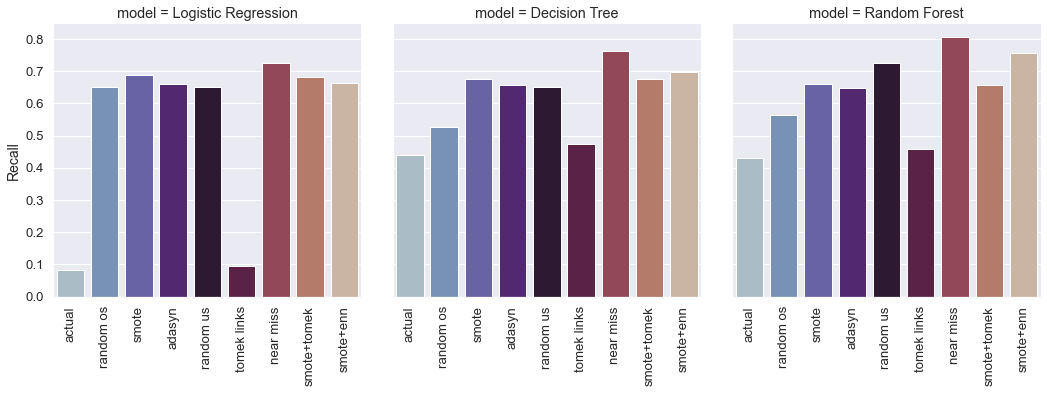

In [91]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "recall", palette='twilight', order=["actual", "random os", "smote", "adasyn", "random us", "tomek links", "near miss", "smote+tomek", "smote+enn"])
g.set_xticklabels(rotation=90)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('Recall', fontsize=14)

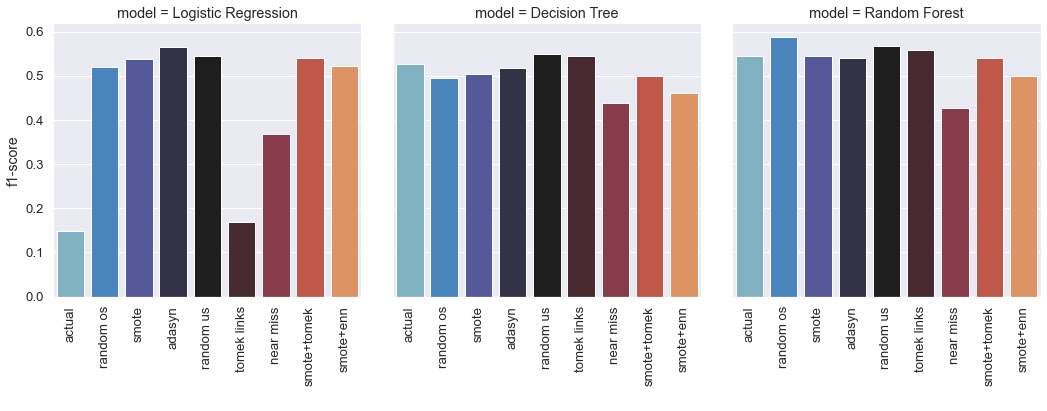

In [92]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "f1-score", palette='icefire', order=["actual", "random os", "smote", "adasyn", "random us", "tomek links", "near miss", "smote+tomek", "smote+enn"])
g.set_xticklabels(rotation=90)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('f1-score', fontsize=14)

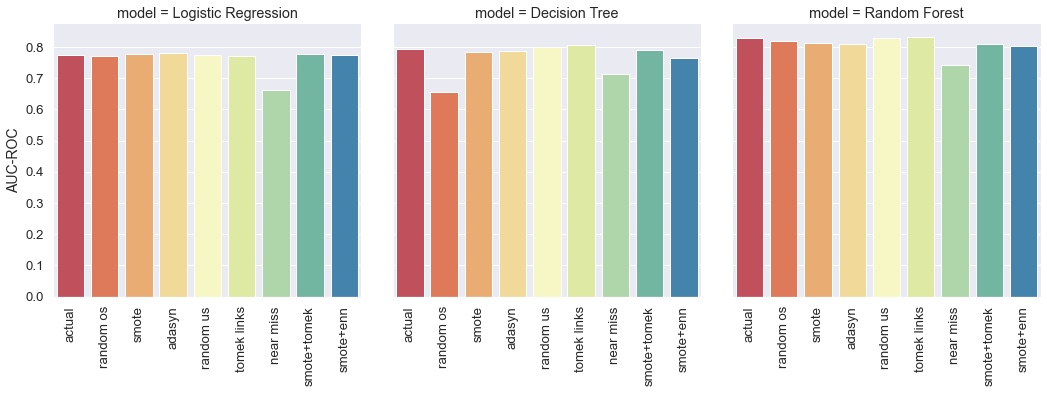

In [93]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "AUC-ROC", palette='Spectral', order=["actual", "random os", "smote", "adasyn", "random us", "tomek links", "near miss", "smote+tomek", "smote+enn"])
g.set_xticklabels(rotation=90)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('AUC-ROC', fontsize=14)

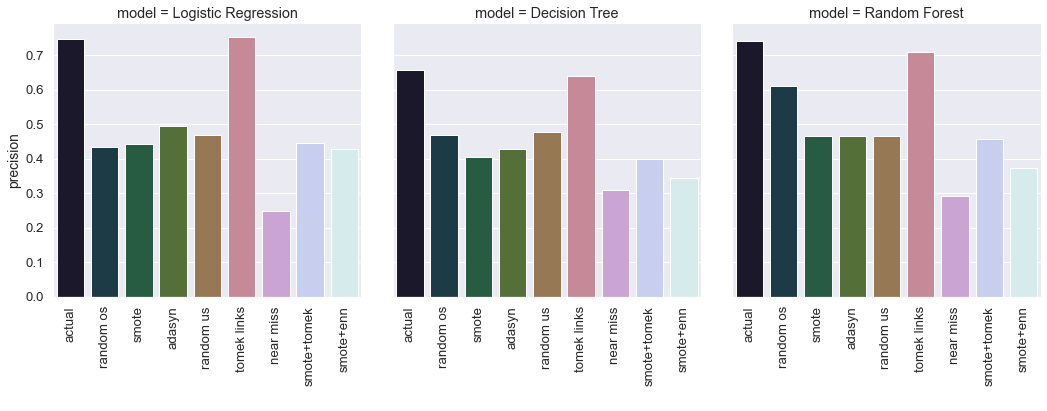

In [94]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "precision", palette='cubehelix', order=["actual", "random os", "smote", "adasyn", "random us", "tomek links", "near miss", "smote+tomek", "smote+enn"])
g.set_xticklabels(rotation=90)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('precision', fontsize=14)